# CIFAR-10 이미지 생성하기

## 1. 데이터셋 구성

In [21]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [22]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

In [23]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [24]:
# 이미지를 [-1, 1]로 정규화
# 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눈다.

def normalize(train):
    return (train - 127.5) / 127.5

def inv_normalize(train):
    return (127.5 * train) + 127.5

train_x = normalize(train_x)

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


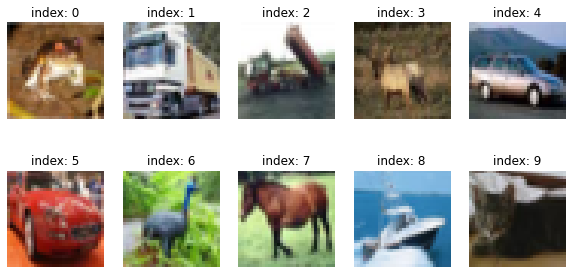

In [25]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(inv_normalize(train_x[i]).astype(np.int32).reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [26]:
# 미니배치 데이터셋 구성
BUFFER_SIZE = 50000 # BUFFER_SIZE는 전체 데이터를 섞기 위해 50000으로 설정
BATCH_SIZE = 256 # BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

## 2. 생성자 모델 구현

In [27]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.3))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.3))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.3))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)        204800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)       

* Conv2DTranspose : 일반적인 Conv2D와 반대로 이미지 사이즈를 넓히는 Layer
* BatchNormalization : 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜 줌
* LeakyReLU : 활성화 함수
* 마지막 활성화 함수로는 tanh를 사용해 -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 만든다.

Shape of Generated Image :  (1, 32, 32, 3)


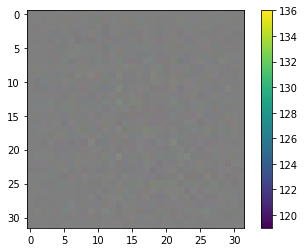

In [28]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
print("Shape of Generated Image : ", generated_image.shape)

plt.imshow(inv_normalize(generated_image[0].numpy()).astype(np.int32))
plt.colorbar()
plt.show()

## 3. 판별자 모델 구현

In [29]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

* Conv2D Layer를 통해 이미지의 크기를 줄인다.
* 마지막 Flatten Layer를 통해 3차원 이미지를 1차원으로 축소한 뒤 Dense Layer를 거쳐 하나의 값 만을 출력한다.

In [30]:
# 위에서 생성한 가짜 이미지를 판별자에 입력시켜 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00233974]], dtype=float32)>

* Tensor 형태로 출력되는 결과값은 아직은 의미가 없다.

## 4. 손실함수와 최적화 함수 구현
### (1) 손실함수

In [31]:
# Loss Function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### (2) 최적화 함수

In [ ]:
# Optimizer(Adam)
# 생성자와 구분자는 따로 학습을 진행하는 개별 네트워크이므로 optimizer를 따로 만든다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 5. 훈련 과정 상세 기능 구현

In [33]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [34]:
# 샘플 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = inv_normalize(predictions[i, :, :, :].numpy()).astype(np.int32) # 역정규화
        plt.imshow(img)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [36]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
## 6. 학습 과정 진행

In [37]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [38]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

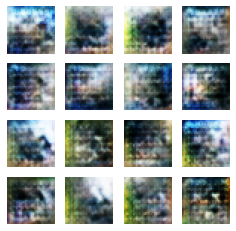

Time for training : 15531 sec


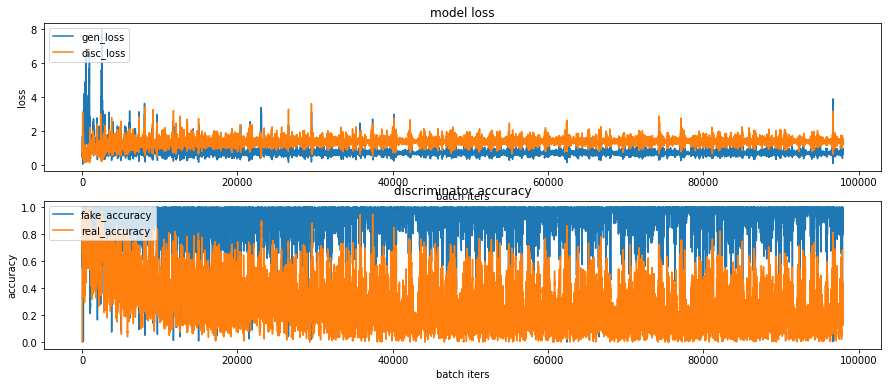

CPU times: user 4h 18min 29s, sys: 4min 56s, total: 4h 23min 25s
Wall time: 4h 18min 54s


In [39]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

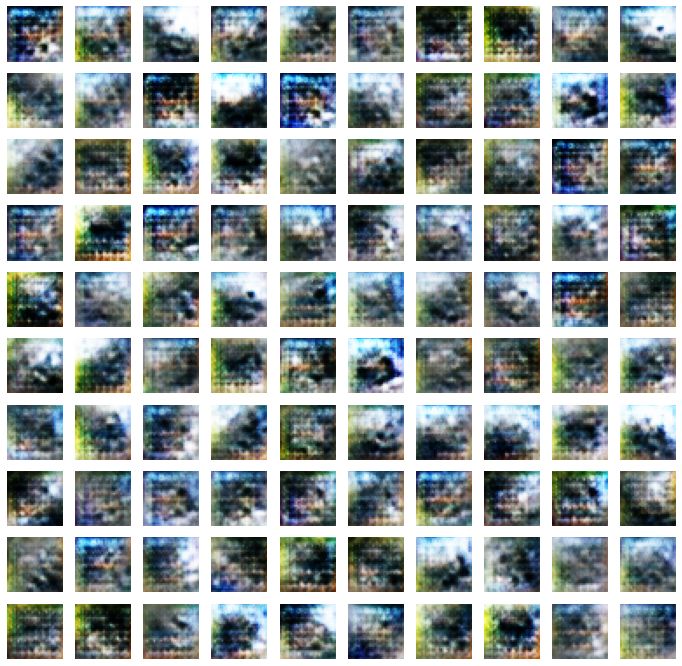

In [40]:
#checkpoint 모듈을 활용하여 모델을 로드
#학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있음.
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints3'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

#로드한 모델이 정상적으로 이미지를 생성하는지 확인. 
plt.figure(figsize=(12, 12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   #역정규화를 하여 이미지를 출력
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()

## 7. GAN 개선하기

### (1) Baseline 결과

In [47]:
from IPython.display import Image

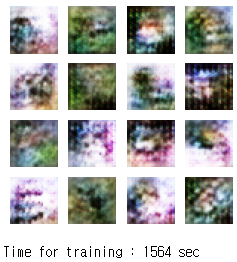

In [51]:
# Baseline Code의 Training 결과
Image('/aiffel/aiffel/AIFFEL_Exploration/E13_CIFAR10_Generative/img/base_train.png')

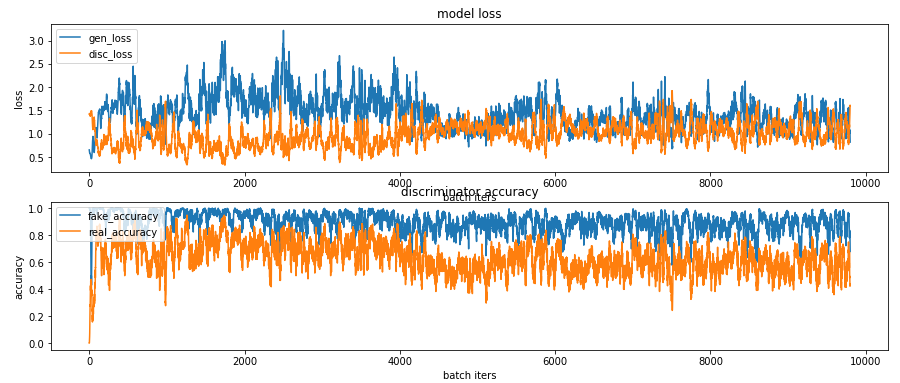

In [50]:
# Baseline Code의 Loss와 Accuracy
Image('/aiffel/aiffel/AIFFEL_Exploration/E13_CIFAR10_Generative/img/base_loss&accuracy.png')

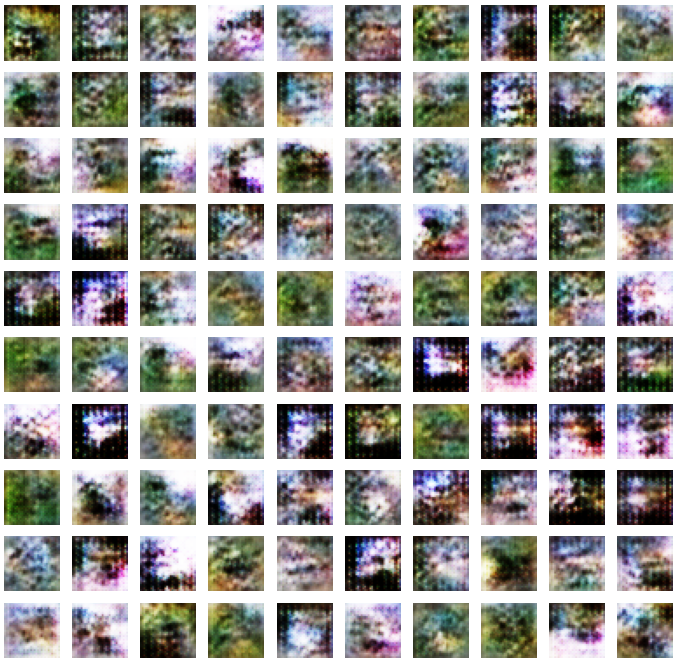

In [52]:
# Baseline Code의 Generation Image
Image('/aiffel/aiffel/AIFFEL_Exploration/E13_CIFAR10_Generative/img/base_generation.png')

* Epoch을 50으로 설정한 Baseline의 경우 이미지에서 특징적인 객체를 찾기가 어렵다.
* Loss 역시 0에 수렴한다고 볼 수는 없고, fake accuracy 역시 높은 값을 가지며 결과가 좋지 않다.

### (2) 파라미터 변경
* Epoch을 200으로 설정

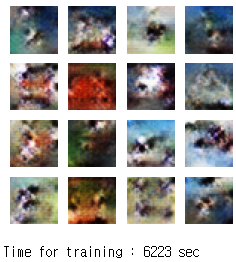

In [53]:
# 변경된 Code의 Training 결과
Image('/aiffel/aiffel/AIFFEL_Exploration/E13_CIFAR10_Generative/img/test1_train.png')

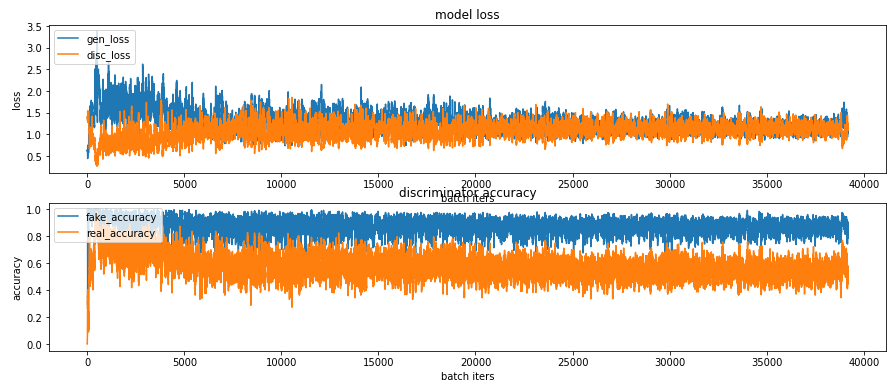

In [54]:
# 변경된 Code의 Loss&Accuracy 결과
Image('/aiffel/aiffel/AIFFEL_Exploration/E13_CIFAR10_Generative/img/test1_loss&accuracy.png')

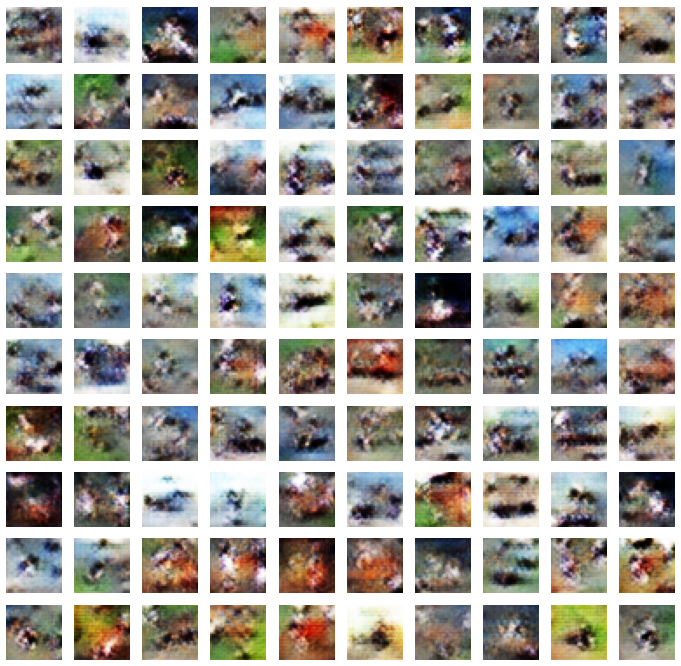

In [55]:
# 변경된 Code의 Generation Image 결과
Image('/aiffel/aiffel/AIFFEL_Exploration/E13_CIFAR10_Generative/img/test1_generation.png')

* Epoch을 200으로 늘리기만 해도 사진에서 알아볼 수는 없지만 객체라고 할 만한 것이 존재한다.

## 정리
* 이 노트북에서는 다음과 같이 파라미터를 설정하고, 모델을 구성했다.
  * BatchNormalization을 제거했다.
  * LeakyReLU의 파라미터 alpha 값을 0.3으로 지정했다.
  * Epoch을 500으로 설정했다.
* 결과적으로는 오히려 Epcoh을 200으로 높인 모델에 비해 객체를 구분하기가 더욱 어려웠고, Epoch을 50만큼만 진행한 Baseline 모델 수준의 결과를 보였다.
* BatchNormalization을 제거함으로써 신경망의 가중치가 급격히 증가해 문제가 발생했을 것이라고 생각된다.